In [296]:
import pandas as pd
import geopandas as gpd
import db_dtypes
import matplotlib.pyplot as plt 
import folium
from shapely.geometry import Point, Polygon, LineString
from shapely import intersection
%matplotlib inline


In [273]:
# create a simple polygon
p1 = Polygon([(0, 0), (1, 0), (1.25, 0.4), (2, 0.7), (1, 1), (1,1.3), (0, 1)])
#p2 = Polygon([(1, 0), (2, 0), (2, 1), (1, 1)])
p2 = Polygon([(2, 0), (3, 0), (3.3,1.5), (3, 3), (2, 2)])

#Create points
pt1 = Point([(0, 0), (1, 0), (1.25, 0.4), (2, 0.7), (1, 1), (1,1.3), (0, 1)])
pt2 = Point([(2, 0), (3, 0), (3.3,1.5), (3, 3), (2, 2)])

ValueError: Point() takes only scalar or 1-size vector arguments, got ([(0, 0), (1, 0), (1.25, 0.4), (2, 0.7), (1, 1), (1, 1.3), (0, 1)],)

In [274]:
attribs = {'id': ['A', 'B']}
#attribs = {'id': ['A']}

In [35]:
g = gpd.GeoDataFrame(attribs, geometry=[p1,p2])

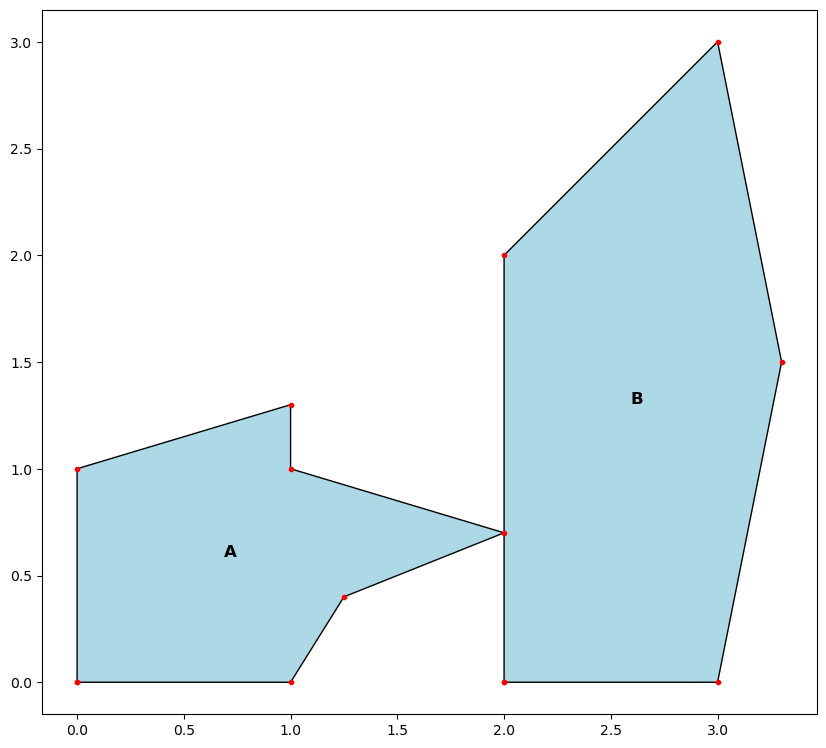

In [61]:
# visualize all polygons with their owner values
fig, ax = plt.subplots(figsize=(10, 10))
g.plot(ax=ax, edgecolor='black', facecolor='lightblue')

# Annotating each polygon with the 'owner' value at its centroid
for idx, row in g.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['id'], horizontalalignment='center', fontsize=12, weight='bold')
    x, y = row.geometry.exterior.xy
    ax.plot(x, y, 'ro', markersize=3)
plt.show()

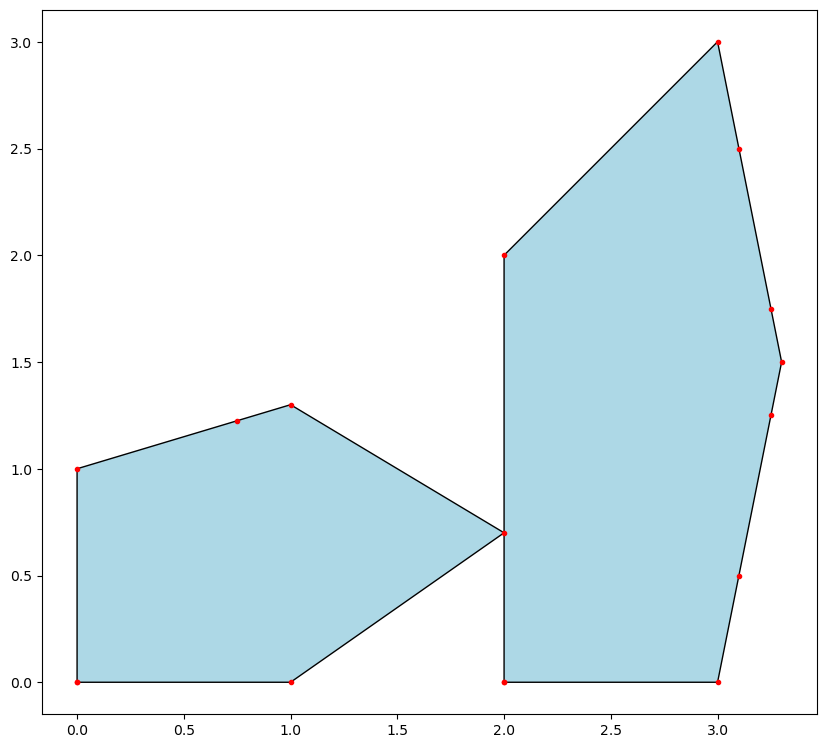

In [112]:
# Add extra vertices to help maintain overall shape of polygon
segment = g.segmentize(max_segment_length=0.3)

g2 = gpd.GeoDataFrame(attribs, geometry=segment)

g2=g2.set_crs(epsg=32610)
crs = g2.crs
unit = crs.axis_info[0].unit_name

#g2['geometry']= g2.geometry.buffer(0.5,cap_style='flat')
g2['geometry'] = g2.geometry.convex_hull
#g2['geometry'] = g2.geometry.concave_hull()

# visualize all polygons with their owner values
fig, ax = plt.subplots(figsize=(10, 10))
g2.plot(ax=ax, edgecolor='black', facecolor='lightblue')

# Annotating each polygon with the 'owner' value at its centroid
for idx, row in g2.iterrows():
    x, y = row.geometry.exterior.xy
    ax.plot(x, y, 'ro', markersize=3)



In [ ]:
simplify = g2.simplify(0.4)
print(simplify)
g3 = gpd.GeoDataFrame(attribs, geometry=simplify)

# visualize all polygons with their owner values
fig, ax = plt.subplots(figsize=(10, 10))
g3.plot(ax=ax, edgecolor='black', facecolor='lightblue')

# Annotating each polygon with the 'owner' value at its centroid
for idx, row in g3.iterrows():
    x, y = row.geometry.exterior.xy
    ax.plot(x, y, 'ro', markersize=3)


In [ ]:
g2['geometry']= g2.geometry.buffer(0.5,cap_style='flat')
# visualize all polygons with their owner values
fig, ax = plt.subplots(figsize=(10, 10))
g2.plot(ax=ax, edgecolor='black', facecolor='lightblue')

# Annotating each polygon with the 'owner' value at its centroid
for idx, row in g2.iterrows():
    x, y = row.geometry.exterior.xy
    ax.plot(x, y, 'ro', markersize=3)

In [140]:
gdf = gpd.read_file("vexcel_selection.shp")


# Drop columns multiple column 
gdf = gdf.drop(['id_left', 'index_righ','id_right'], axis=1)
gdf



,geometry
0,"POLYGON ((-122.62555 38.23676, -122.62553 38.2..."
1,"POLYGON ((-122.62548 38.23672, -122.62545 38.2..."


In [141]:
# Get centroid locations
bounds = gdf.total_bounds
centroid_x = (bounds[0] + bounds[2]) / 2
centroid_y = (bounds[1] + bounds[3]) / 2
print(centroid_x, centroid_y)

-122.62550925157649 38.236679420085196


In [199]:
# Perform a self-spatial join using the 'intersects' predicate
overlaps = gpd.sjoin(gdf, gdf,how="inner", predicate="overlaps")

# Filter out self-intersections
overlaps = overlaps[overlaps.index != overlaps.index_right]

overlaps

,geometry,index_right
0,"POLYGON ((-122.62555 38.23676, -122.62553 38.2...",1
1,"POLYGON ((-122.62548 38.23672, -122.62545 38.2...",0


In [202]:
overlaps=overlaps.to_crs(epsg=32610)
simplify = overlaps.simplify(0.8)
print(simplify)
g3 = gpd.GeoDataFrame(attribs, geometry=simplify)

0    POLYGON ((532769.401 4232150.36, 532771.809 42...
1    POLYGON ((532776.332 4232146.077, 532778.448 4...
dtype: geometry


In [205]:
# OpenStreetMap
map = folium.Map(location=[centroid_y, centroid_x], tiles="OpenStreetMap", zoom_start=25)
folium.GeoJson(overlaps).add_to(map)
#folium.GeoJson(g3).add_to(map)
map

In [249]:

shapes = gpd.read_file("vexcel_selection.shp")
crs = shapes.crs

# OpenStreetMap
map = folium.Map(location=[centroid_y, centroid_x], tiles="OpenStreetMap", zoom_start=25)
folium.GeoJson(shapes).add_to(map)
map

In [250]:
shapes.head()   


,id,geometry
0,1,"POLYGON ((-122.62555 38.23676, -122.62553 38.2..."
1,2,"POLYGON ((-122.62548 38.23672, -122.62545 38.2..."


In [275]:
shapes = gpd.read_file("vexcel_selection.shp")


In [297]:

data_overlaps=gpd.GeoDataFrame(columns=['id','geometry'],geometry='geometry', crs=shapes.crs)

for index, row in shapes.iterrows():
    row_geom = row.geometry
    row_id = row.id
    data_temp1 = shapes.loc[shapes.id!=row_id]
    print(f'data temp: {data_temp1.id}')
    # check if intersection occured
    overlaps=data_temp1[data_temp1.geometry.overlaps(row.geometry)]['id'].tolist()


    if len(overlaps)>0:
        temp_list=[]


        # compare the area with threshold

        
        for y in overlaps:
            overlap_geom = shapes.loc[shapes.id==y, 'geometry'].values[0]
            intersect_geom = intersection(row_geom, overlap_geom)
            #temp_area=gpd.overlay(,shapes.loc[shapes.id==row.id,],how='intersection')

            #data_overlaps=gpd.GeoDataFrame(pd.concat([temp_area,data_overlaps],ignore_index=True),crs=shapes.crs)
            #data_overlaps = pd.concat([data_overlaps,temp_area],ignore_index=True)

    break
# data_overlaps.to_file('overlaps.shp')
# # get unique of list id
# data_overlaps['sorted']=data_overlaps.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
# #data_overlaps['sorted']=data_overlaps.sorted.apply(lambda y: ''.join(y))
# #data_overlaps=data_overlaps.drop_duplicates('sorted')
# #data_overlaps=data_overlaps.reset_index()[['id_1','id_2','geometry']]

data temp: 1    2
Name: id, dtype: int64


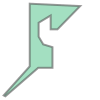

In [298]:
intersect_geom

In [257]:
data_temp1

,id,geometry
1,2,"POLYGON ((-122.62548 38.23672, -122.62545 38.2..."


In [299]:
# OpenStreetMap
map = folium.Map(location=[centroid_y, centroid_x], tiles="OpenStreetMap", zoom_start=25)
folium.GeoJson(intersect_geom).add_to(map)
#folium.GeoJson(g3).add_to(map)
map

In [300]:
fixed_geom = shapes.symmetric_difference(intersect_geom)
# OpenStreetMap
map = folium.Map(location=[centroid_y, centroid_x], tiles="OpenStreetMap", zoom_start=25)
folium.GeoJson(fixed_geom).add_to(map)
map

#fixed_geom.to_file('fixed.shp')

In [303]:
fixed_geom = fixed_geom.reset_index()
fixed_geom

,index,0
0,0,"POLYGON ((-122.62553 38.23678, -122.62549 38.2..."
1,1,"POLYGON ((-122.62545 38.23674, -122.62538 38.2..."


In [304]:
from shapely.ops import unary_union

In [305]:
fixed_reproj = fixed_geom.to_crs(epsg=32610)
fixed_reproj.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

C:\Users\klemay\AppData\Local\Temp\2\ipykernel_4164\1849861734.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  fixed_union = fixed_reproj.unary_union


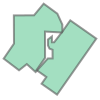

In [306]:
fixed_union = fixed_reproj.unary_union

#fixed_geom_buff = new.buffer(50).buffer(-50)

In [308]:
[fixed_union]

[<MULTIPOLYGON (((532784.949 4232144.541, 532775.155 4232130.564, 532771.294 ...>]

In [310]:
fixed_union_gdf = gpd.GeoDataFrame(geometry=[fixed_union], crs=32610)
fixed_union_gdf

,geometry
0,"MULTIPOLYGON (((532784.949 4232144.541, 532775..."


In [313]:
fixed_union_gdf['geometry'] = fixed_union_gdf['geometry'].buffer(50)
fixed_union_gdf['geometry'] = fixed_union_gdf['geometry'].buffer(-50)

In [314]:
# OpenStreetMap
map = folium.Map(location=[centroid_y, centroid_x], tiles="OpenStreetMap", zoom_start=25)
folium.GeoJson(fixed_union_gdf).add_to(map)
map

In [242]:
#new=fixed_geom.to_crs(epsg=32610)

for index, row in shapes.iterrows():
    geom = row['geometry']
    geom.buffer(-1, join_style="mitre").buffer(1, join_style="mitre")

In [233]:
buffer2 = buff.buffer(-0.5, join_style="mitre").buffer(5, join_style="mitre")

In [234]:
# OpenStreetMap
map = folium.Map(location=[centroid_y, centroid_x], tiles="OpenStreetMap", zoom_start=25)
folium.GeoJson(buffer2).add_to(map)
map